In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

In [14]:
def plot_plane(a, b, c, d, x1, y1, z1, x2, y2, z2, x3, y3, z3, export = False):
    x, y = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = (-d - a * X - b * Y) / c
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    ax.plot(x1, y1, z1, "ro")
    ax.plot(x2, y2, z2, "ro")
    ax.plot(x3, y3, z3, "ro")

    if export :
        plt.savefig("plane.png")
    
    else :
        plt.show()

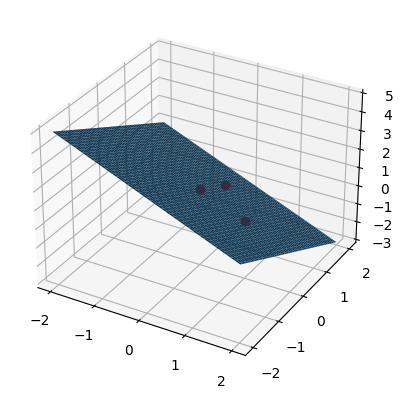

In [15]:
a, b, c, d = 1, 1, 1, -1
x1, y1, z1 = (1, 0, 0)
x2, y2, z2 = (0, 1, 0)
x3, y3, z3 = (0, 0, 1)

plot_plane(a, b, c, d, x1, y1, z1, x2, y2, z2, x3, y3, z3)

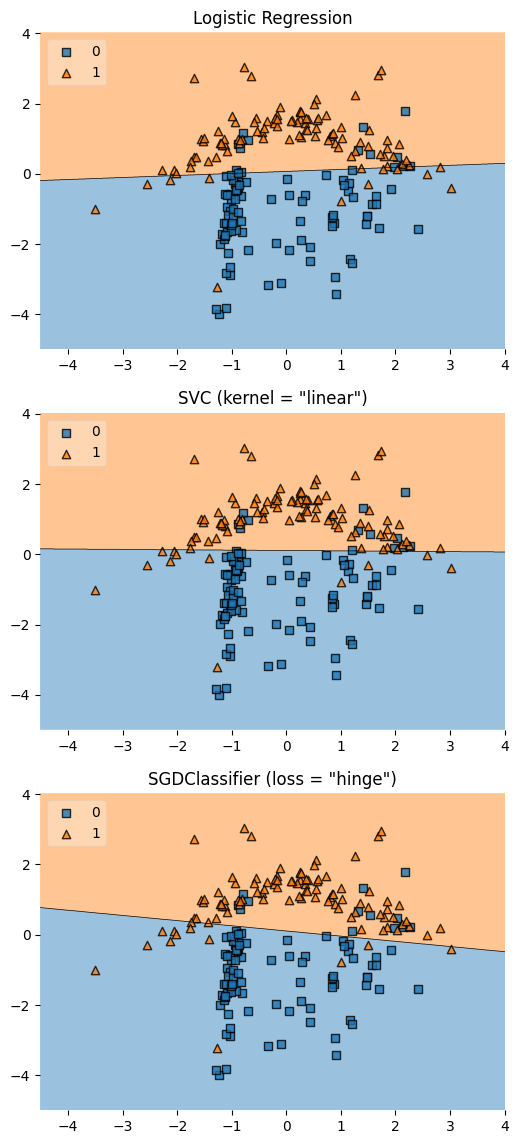

In [25]:
# Visualise decision boundary for classifiers
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=1)

clf1 = LogisticRegression()
clf2 = SVC(kernel="linear")
clf3 = SGDClassifier(loss = "hinge")

gs = gridspec.GridSpec(3, 1)
fig = plt.figure(figsize=(6,14))

labels = ['Logistic Regression', 'SVC (kernel = "linear")', 'SGDClassifier (loss = "hinge")']
for clf, lab, grd in zip([clf1, clf2, clf3],
                         labels,
                         [0, 1, 2]):
 
    clf.fit(X, y)
    # print(grd)
    ax = plt.subplot(gs[grd, 0])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
 
plt.show()